# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [4]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
from langdetect import detect
from textblob import TextBlob
from wordcloud import WordCloud
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [5]:
# Le doy formato a los gráficos
sns.set_style("darkgrid")
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [26]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2021-08-22 20:42:29 -03:00)


In [77]:
# Definimos si queres procesar el dataset crudo
READ_RAW = False
DETECT_LANG = True

time: 0 ns (started: 2021-08-22 21:14:03 -03:00)


In [23]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

time: 0 ns (started: 2021-08-22 20:42:08 -03:00)


**Reviews**

In [6]:
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

0it [00:00, ?it/s]

time: 8min 47s (started: 2021-08-21 21:58:45 -03:00)


In [18]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

time: 7.58 s (started: 2021-08-22 20:41:42 -03:00)


In [19]:
data_reviews.head(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030368.0000,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396848.0000,NaN,NaN
5,Szudof,0.2000,155.0000,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,NaN,Product received for free,3.0000
6,Vonder,2.7000,264.0000,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497328.0000,NaN,NaN
7,LucaFox,4.0000,136.0000,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674480.0000,NaN,1.0000
8,rampage1209,34.8000,3.0000,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474368.0000,NaN,NaN
9,Devil Azite,0.1000,548.0000,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,NaN,Product received for free,1.0000


time: 16 ms (started: 2021-08-22 20:41:49 -03:00)


In [37]:
data_reviews.isna().sum()

username            18
hours             2625
products          1564
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         460624
compensation    762923
found_funny     657709
dtype: int64

time: 203 ms (started: 2021-08-22 20:54:33 -03:00)


In [36]:
data_reviews.dropna(subset=['text'], axis=0, inplace=True)

time: 235 ms (started: 2021-08-22 20:54:29 -03:00)


In [38]:
data_reviews.isna().sum()

username            18
hours             2625
products          1564
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         460624
compensation    762923
found_funny     657709
dtype: int64

time: 171 ms (started: 2021-08-22 20:54:44 -03:00)


**Games**

In [24]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

time: 3.34 s (started: 2021-08-22 20:42:12 -03:00)


In [25]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


time: 16 ms (started: 2021-08-22 20:42:16 -03:00)


Vamos a reducir las columnas de *'data_reviews'*

In [39]:
data_reviews.columns

Index(['username', 'hours', 'products', 'product_id', 'page_order', 'date',
       'text', 'early_access', 'page', 'user_id', 'compensation',
       'found_funny'],
      dtype='object')

time: 0 ns (started: 2021-08-22 20:55:09 -03:00)


In [72]:
df_reviews = data_reviews[['username', 'product_id', 'text', 'found_funny', 'hours']]
df_reviews.head()

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,NaN,7.8000
4,the_maker988,35140,"This game was way to linear for me, and compar...",NaN,8.2000


time: 47 ms (started: 2021-08-22 21:11:59 -03:00)


In [73]:
# Creamos método para eliminar los caracteres que no sean letras
def cleanText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^A-Za-z]"," ",str(text))
    return text

time: 0 ns (started: 2021-08-22 21:11:59 -03:00)


In [74]:
# Aplicamos el método a la columna de texto
df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)

  0%|          | 0/777468 [00:00<?, ?it/s]

time: 23.8 s (started: 2021-08-22 21:12:00 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/3662698852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)


In [75]:
df_reviews

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000
...,...,...,...,...,...
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000
779303,Nikolai Belinski,252490,Coolest Game Eva,NaN,55.1000
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000
779305,Jerry,252490,Great game,NaN,139.8000


time: 15 ms (started: 2021-08-22 21:12:24 -03:00)


Detectar idioma del texto

In [76]:
# Creamos función para detectar idioma
def getLang(text):
    try:
        lang = detect(text)                                     
    except:
        lang = np.NaN
    return lang

time: 0 ns (started: 2021-08-22 21:12:50 -03:00)


In [80]:
if DETECT_LANG:
    df_reviews['lang'] = df_reviews['text'].progress_apply(getLang)

  0%|          | 0/777468 [00:00<?, ?it/s]

time: 1h 44min 16s (started: 2021-08-22 21:14:49 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/763176423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['lang'] = df_reviews['text'].progress_apply(getLang)


In [81]:
if DETECT_LANG:
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv', index_col='index')

time: 8.89 s (started: 2021-08-22 23:09:16 -03:00)


In [83]:
df_reviews.lang.unique()

array(['en', nan, 'so', 'pl', 'de', 'it', 'fr', 'ca', 'sw', 'tr', 'af',
       'hr', 'tl', 'no', 'es', 'ro', 'vi', 'nl', 'sq', 'cy', 'pt', 'id',
       'lv', 'et', 'hu', 'lt', 'da', 'sl', 'sk', 'fi', 'sv', 'cs', 'uk'],
      dtype=object)

time: 32 ms (started: 2021-08-22 23:09:33 -03:00)


In [84]:
code = pd.read_csv('lang_code3.csv')
code_dict = code.set_index('code').to_dict()['language_name']
df_reviews['lang'] = df_reviews['lang'].map(code_dict)

time: 438 ms (started: 2021-08-22 23:09:43 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/204944570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['lang'] = df_reviews['lang'].map(code_dict)


In [85]:
idiomas = df_reviews.groupby('lang').count()['username'].sort_values(ascending=False)

time: 312 ms (started: 2021-08-22 23:09:46 -03:00)


In [86]:
idiomas.index

Index(['English', 'Somali', 'German', 'Afrikaans', 'Tagalog', 'Welsh',
       'Norwegian', 'Danish', 'Romanian', 'Spanish', 'Dutch', 'Catalan',
       'French', 'Indonesian', 'Italian', 'Polish', 'Portuguese', 'Turkish',
       'Estonian', 'Swahili', 'Slovenian', 'Albanian', 'Croatian',
       'Vietnamese', 'Swedish', 'Finnish', 'Hungarian', 'Slovak', 'Lithuanian',
       'Latvian', 'Czech', 'Ukrainian'],
      dtype='object', name='lang')

time: 0 ns (started: 2021-08-22 23:09:51 -03:00)


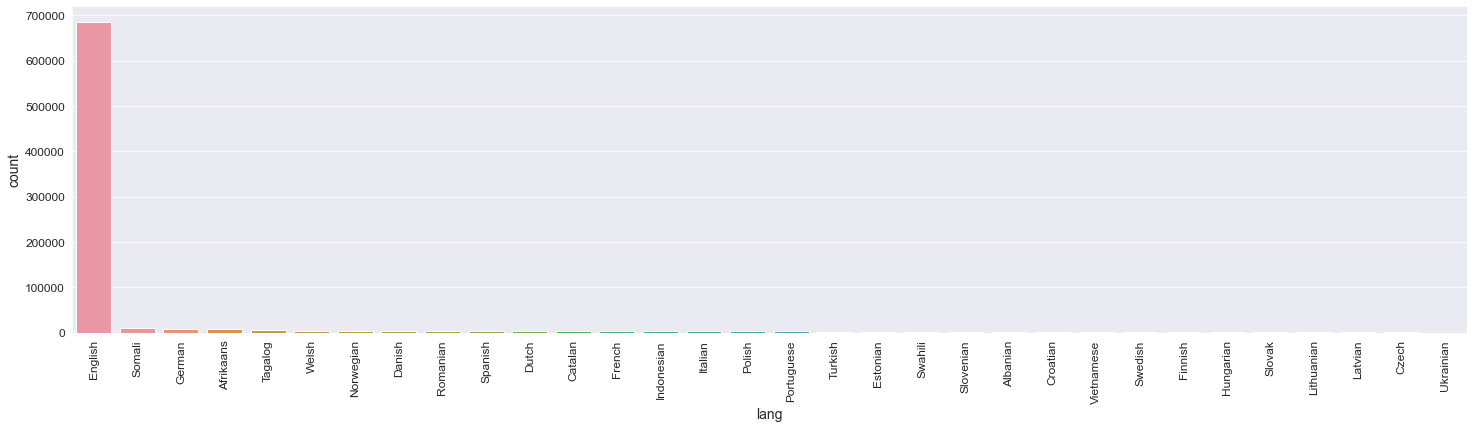

time: 985 ms (started: 2021-08-22 23:09:58 -03:00)


In [88]:
# Graficamos el conteo de los distintos idiomas encontrados en el dataset
plt.figure(figsize=(25,6))
sns.countplot(data=df_reviews, x='lang', order=idiomas.index[0:])
plt.xticks(rotation=90)
plt.show()

Vemos claramante que el idioma predominantes es el inglés. Algo llamativo es que el segundo más abundante es el "Somalí". Vamos a analizar más en detalle, filtrando esas instancias.

In [91]:
df_reviews[df_reviews.lang == 'Somali'].head(20)

,username,product_id,text,found_funny,hours,lang
31,JessetheGengar,302390,baaaddddddd,NaN,0.4000,Somali
247,69:The Best Position,271590,good,NaN,176.3000,Somali
354,Santiago ♥D,308040,bad,1.0000,1.3000,Somali
445,brokensteelcache,224900,too good to play,1.0000,1.3000,Somali
601,𝖊𝖃𝖔 | Psycocat,308040,good game,NaN,3.2000,Somali
617,Vukishaa,308040,good,NaN,3.3000,Somali
698,Dicather,441050,YEAH IT CAN INTO SPACE,NaN,1.6000,Somali
718,MyAcidicPapaya,341720,good,NaN,0.8000,Somali
741,✪ B1ACKOUT,271590,good game,NaN,12.1000,Somali
951,L0lHeLetMeUseHisLapTop,291550,gud,NaN,19.4000,Somali


time: 78 ms (started: 2021-08-22 23:10:27 -03:00)


Por lo que podemos observar, se trata de una mala predicción, ya que los comentarios están en inglés. Por alguna razón (quizás por las faltas de ortografía) los etiqueta como Somalí.
De todos modos, siendo que la cantidad de comentarios predichos como Inglés representan un gran porcentaje, vamos a eliminar aquellas instancias en otro idioma.

In [92]:
mask = df_reviews.lang == 'English'
df_reviews.drop(df_reviews[~mask].index, inplace=True)
df_reviews

C:\Users\elmai\.conda\envs\datascience\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,username,product_id,text,found_funny,hours,lang
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English
...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English
779305,Jerry,252490,Great game,NaN,139.8000,English


time: 203 ms (started: 2021-08-22 23:11:04 -03:00)


In [93]:
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Traemos las stopwords
stopwords = set(stopwords.words('english'))

time: 31 ms (started: 2021-08-22 23:11:19 -03:00)


In [94]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text=re.sub("[^a-zA-Z]"," ",str(text))
    # Pasamos todo a minúsculas
    text=text.lower()
    # Tokenizamos para separar las palabras del titular
    text=tokenizer.tokenize(text)
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra)>3]
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

time: 0 ns (started: 2021-08-22 23:11:20 -03:00)


In [95]:
# Aplicamos la transformación
df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)

  0%|          | 0/685202 [00:00<?, ?it/s]

time: 43.3 s (started: 2021-08-22 23:11:28 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/1392708714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)


In [96]:
# Mostramos el dataset limpio
df_reviews.iloc[np.random.choice(df_reviews.index, size=5)]

,username,product_id,text,found_funny,hours,lang,cleaned_text
709864,[LOST] Spedsnaz,214950,Still has glitches even though emperor Editio...,NaN,209.4000,English,still glitches even though emperor edition unl...
553964,Terror Terje,575950,Great maps and gameplay,NaN,0.5000,English,great maps gameplay
411294,Tar171,18500,fun little game to waste time with,NaN,25.0000,English,little game waste time
356581,Life,284160,One of the best driving and crashing simulator...,NaN,115.6000,English,best driving crashing simulators seen would re...
392411,Ryerson,440,freshness spookiness would recommend,NaN,955.3000,English,freshness spookiness would recommend


time: 125 ms (started: 2021-08-22 23:12:11 -03:00)


In [97]:
df_reviews.head(10)

,username,product_id,text,found_funny,hours,lang,cleaned_text
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...
6,Vonder,35600,I like the art style and the idea but what a b...,NaN,2.7000,English,like style idea boring miserable excuse puzzle...
7,LucaFox,620900,Very very good game I love dungeon crawlers ...,1.0000,4.0000,English,good game love dungeon crawlers roguelikes lig...
8,rampage1209,1840,WAY PAST COOL,NaN,34.8000,English,past cool
9,Devil Azite,671270,Putting a hat on your head has disasterous rep...,1.0000,0.1000,English,putting head disasterous repercussions
10,MrNinjaSquirrel,288690,It s like Sudoku but as a ball I have to i...,NaN,1.2000,English,like sudoku ball imagine sort brainstorming ex...


time: 16 ms (started: 2021-08-22 23:12:35 -03:00)


In [98]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

time: 343 ms (started: 2021-08-22 23:12:39 -03:00)


In [99]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

time: 47 ms (started: 2021-08-22 23:12:40 -03:00)


In [100]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def polarity(text):
    return TextBlob(text).sentiment.polarity

time: 0 ns (started: 2021-08-22 23:12:43 -03:00)


In [101]:
df_reviews['subj'] = df_reviews['text'].progress_apply(subjectivity)

  0%|          | 0/685202 [00:00<?, ?it/s]

time: 5min 38s (started: 2021-08-22 23:13:04 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/3315775322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['subj'] = df_reviews['text'].progress_apply(subjectivity)


In [102]:
df_reviews['pola'] = df_reviews['text'].progress_apply(polarity)

  0%|          | 0/685202 [00:00<?, ?it/s]

time: 6min 4s (started: 2021-08-22 23:18:43 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_32/362596473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['pola'] = df_reviews['text'].progress_apply(polarity)


In [103]:
df_reviews

,username,product_id,text,found_funny,hours,lang,cleaned_text,subj,pola
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...,0.0000,0.0000
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...,0.4250,0.0417
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...,0.5484,0.1652
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...,0.3688,0.1187
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...,0.5333,-0.1200
...,...,...,...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English,good laugh friends cannot wait till added,0.4000,0.5000
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English,summary rust survival game created facepunch s...,0.5183,-0.2125
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English,rust best survival sandbox game market playing...,0.4085,0.1573
779305,Jerry,252490,Great game,NaN,139.8000,English,great game,0.5750,0.2000


time: 31 ms (started: 2021-08-22 23:24:47 -03:00)


In [104]:
df_reviews.sort_values(by='subj').iloc[650000:650050]

,username,product_id,text,found_funny,hours,lang,cleaned_text,subj,pola
331076,purwadinugroho86,291410,Get rid of the key system and its better than...,NaN,100.6000,English,system better blizzard,0.7500,0.2500
525580,littleleoness,363970,It s ok I guess Psych I m obsessed,NaN,15.0000,English,guess psych obsessed,0.7500,0.0000
482076,Korven Kuningas,627690,It s the rp added ver of clicker heroes It s ...,NaN,392.8000,English,added clicker heroes always nice heroes forgot...,0.7500,0.5500
258167,Blind and Deaf With Parkinsons,365590,A pretty boring repetitive experience unless y...,1.0000,31.3000,English,pretty boring repetitive experience unless fri...,0.7500,-0.3333
171304,patandspooky,203630,I love this game It is Civ Lite with magic ...,NaN,151.2000,English,love game lite magic drawback lack achiements ...,0.7500,0.1500
735498,whydavid,220440,Gameplay is smooth and the story is existent c...,NaN,16.6000,English,gameplay smooth story existent compared predec...,0.7500,0.2000
171850,Teh_Bucket,274290,very nice looking random number generator,4.0000,0.6000,English,nice looking random number generator,0.7500,0.1400
31641,Connor gamdom.com,271590,They fked up modes were great,NaN,152.5000,English,fked modes great,0.7500,0.8000
590844,Zangston,10500,Just play Napoleon Total War,1.0000,0.9000,English,play napoleon total,0.7500,0.0000
618721,Corpse Run,282440,Great investment,NaN,1.5000,English,great investment,0.7500,0.8000


time: 500 ms (started: 2021-08-22 23:24:47 -03:00)


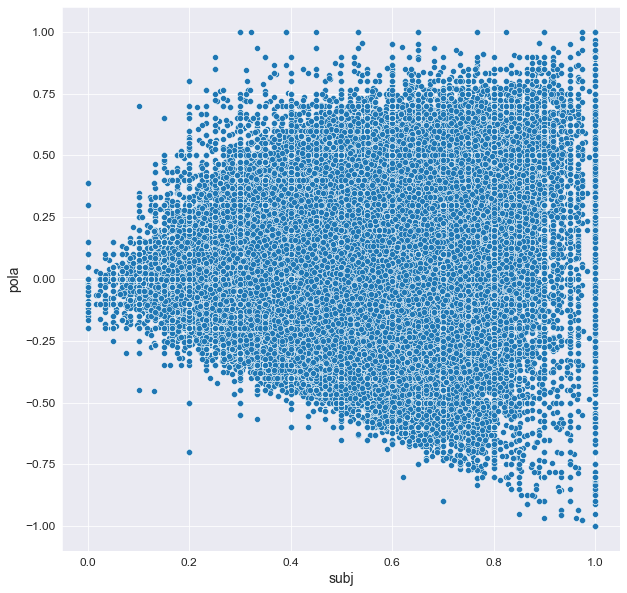

time: 1.58 s (started: 2021-08-22 23:24:47 -03:00)


In [105]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(data=df_reviews, x='subj', y='pola')
# g = sns.histplot(data=df_reviews, x='pola')
# g.set(ylim=(0, 10000))
plt.show()